<div style='text-align:center; font-size:24px'>
<B>Notebook de traitement distribué en local </B>
<br>Projet N° 9 - <I>Réalisez un traitement Big Data sur le Cloud

<div style='text-align:right; font-size:20px; font-weight:bold; font-style: italic' > 
par Jean Vallée

Ce notebook est utilisé pour le traitement sur un environnement local afin de valider le notebook sur un jeu très réduit

# Session Spark

## Lancement

- Sur un poste local, on lance la session Spark puis on crée le contexte
- Sur le Cloud, EMR se charge de ces opérations

In [7]:
from pyspark.sql import SparkSession
spark = (SparkSession
        .builder
        .appName('p9_pyspark_pca_lr')
        .master('local')
        .config('spark.sql.parquet.writeLegacyFormat', 'true')
        .getOrCreate() )
sc = spark.sparkContext

24/09/04 08:58:11 WARN Utils: Your hostname, DesktopUbuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.109 instead (on interface enp2s0)
24/09/04 08:58:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/04 08:58:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/04 08:58:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Liens vers Spark UI 
- Rapports sur jobs, stages, environnement, exécutants et requêtes SQL disponibles sur le port [4040](http://localhost:4040)
- Ces rapports sont enregistrés plus loin

### Dossiers de travail

In [8]:
PATH = './data'
PATH_Data   = PATH + '/Test'
PATH_Result = PATH + '/Results'
print('PATH:        '   + PATH + \
      '\nPATH_Data:   ' + PATH_Data + \
      '\nPATH_Result: ' + PATH_Result)

PATH:        ./data
PATH_Data:   ./data/Test
PATH_Result: ./data/Results


# Modules & fonctions
- pour un traitement local, leur installation est faîte sur un terminal 
- pour le Cloud, elle est faîte à l'amorçage “bootstrap” du cluster

In [9]:
%%sh
pip list | grep -iE 'pandas|numpy|plotly|pip|ipython|spark|tensorflow'

ipython                      8.25.0
numpy                        1.26.4
pandas                       2.2.2
pip                          24.0
pyspark                      3.2.1
tensorflow                   2.17.0
tensorflow-io-gcs-filesystem 0.37.1


## Import

In [10]:
import pandas as pd
import numpy as np
import io
import os
import cv2
import time

In [11]:
import tensorflow as tf

2024-09-04 08:58:30.048378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 08:58:30.052725: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 08:58:30.067235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 08:58:30.086977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 08:58:30.092403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 08:58:31.096289: W tensorflow/compiler/tf2tensorrt/utils/p

In [12]:
from pyspark.sql.functions import pandas_udf, PandasUDFType, element_at, split, col 

# Pré-traitement des DataFrame Spark

## Chargement des fichiers image

In [20]:
images = spark.read.format('binaryFile') \
  .option('pathGlobFilter', '*.jpg') \
  .option('recursiveFileLookup', 'true') \
  .load(PATH_Data)

In [21]:
# During Debug phase, process only a subset of the images 
data_fraction = 0.1
images = images.sample(data_fraction, 0) # fraction of dataset

In [22]:
nb_images = images.count()
print('nb_images =', nb_images)

nb_images = 55


## _Feature Engineering_

### Ajout de _image_id_
Un identifiant de l'image est bien plus court que le long chemin des fichiers

In [23]:
from pyspark.sql.functions import monotonically_increasing_id

In [24]:
images = images.withColumn( 'image_id', monotonically_increasing_id() )

### Ajout de _class_

In [25]:
images = images.withColumn('class', element_at(split(images['path'], '/'),-2))

### Ajout de _class_id_

In [26]:
from pyspark.ml.feature import StringIndexer

Codage des classes en indexes entiers

In [27]:
indexer = StringIndexer(inputCol='class', outputCol='class_id')
images = indexer.fit(images).transform(images)

In [28]:
print(images.printSchema())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)

None


## Suppression de colonnes inutiles

In [29]:
images = images.drop(*['path', 'modificationTime', 'length'])

In [30]:
print(images.printSchema())

root
 |-- content: binary (nullable = true)
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)

None


In [31]:
print(images.drop('content').show(5, False))

+----------+------------+--------+
|image_id  |class       |class_id|
+----------+------------+--------+
|0         |Watermelon  |47.0    |
|1         |Pineapple   |39.0    |
|2         |Rambutan    |43.0    |
|3         |Cantaloupe 2|14.0    |
|8589934592|Pear 2      |31.0    |
+----------+------------+--------+
only showing top 5 rows

None


## Aggrégats
### Distribution de classes

In [32]:
df_count_per_class = images.groupBy('class_id', 'class').count().toPandas()
df_count_per_class['class_id'] = df_count_per_class['class_id'].astype(int)

In [33]:
df_count_per_class.sort_values('class_id').style.hide()

class_id,class,count
0,Apple Golden 3,2
1,Apple Red Yellow 1,2
2,Banana Red,2
3,Eggplant,2
4,Granadilla,2
5,Pepper Red,2
6,Pomegranate,2
7,Apple Golden 2,1
8,Apple Pink Lady,1
9,Apple Red 3,1


### Nombre de classes

In [21]:
nb_classes = len(df_count_per_class)
print('nb_classes =', nb_classes)

nb_classes = 48


### Nombre d'images

In [22]:
nb_images = df_count_per_class['count'].sum()
print('nb_images =', nb_images)

nb_images = 55


## Distribution des images stockées sur S3

In [ ]:
import matplotlib.pyplot as plt

In [46]:
path_list_S3 = 'files_in_S3.txt'
li_headers = ['class', 'filename']
df_images_in_s3 = pd.read_csv(path_list_S3, sep='/', header=None, names=li_headers)
df_distribution_in_s3 = df_images_in_s3['class'].value_counts()

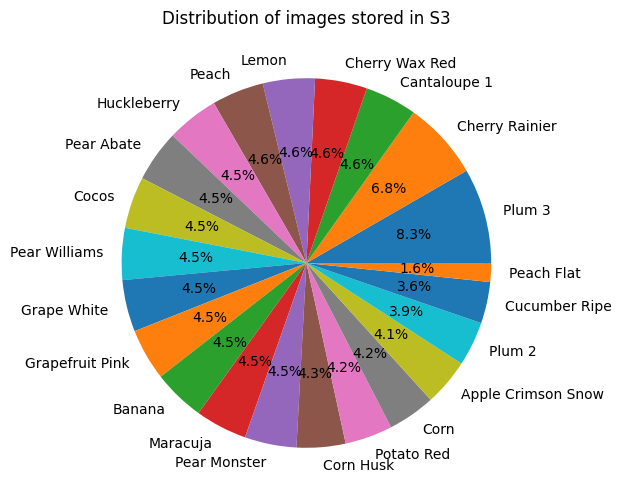

In [64]:
plt.figure(figsize=(6, 6))
plt.pie(df_distribution_in_s3, labels=df_distribution_in_s3.index, autopct='%1.1f%%')
plt.title('Distribution of images stored in S3')
plt.show()

# Remplacement d'attributs originaux
Le modèle de classification choisi requiert une résolution de 224x224x3 couleurs de pixel d’image, ce qui représente 150 258 attributs 

## Génération d'attributs plus représentatifs
Le modèle choisi pour générer des attributs plus représentatifs des images est le modèle neuronal pré-entraîné "Mobil Net V2"

In [23]:
import keras as k

### Récupération du modèle tronqué
- récupère le modèle pré-entraîné 
- le tronque en enlevant la toute dernière couche
- diffuse les poids du modèle
    - depuis le Driver dans le noeud Master
    - vers les Executors dans les noeuds Core

#### Récupération du modèle complet

In [24]:
model = k.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

#### Troncature du modèle
La dernière couche est enlevée pour l'adapter à notre jeu d'images

In [25]:
new_model = k.Model(inputs=model.input,
                  outputs=model.layers[-2].output)

En sortie du modèle tronqué on récupère 1280 attributs par image

In [26]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

#### Diffusion des poids du modèle

In [27]:
sc.broadcast(new_model.get_weights())

### Fonction de changement de résolution des images

In [28]:
def preprocess(content):
    '''
    Preprocesses raw image bytes for prediction.
    '''
    #img = Image.open(io.BytesIO(content)).resize([224, 224])
    nparr = np.frombuffer(content, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    arr = k.preprocessing.image.img_to_array(img)
    return k.applications.mobilenet_v2.preprocess_input(arr)

### Fonctions de génération d’attributs par lots
- Traitement distribuée par lots de DataFrames d’images
    - divise l’ensemble de DataFrames en lots
    - itère sur les lots
    - récupère les résultats de l’ensemble de lots 

#### Fonction de prédiction d'attributs
- fonction Spark UDF de traitement distribué de Pandas
- traite les DataFrames par lots
- charge le modèle une seule fois
- appelle get_predicted_features() par lots 

In [29]:
def get_predicted_features(model, content_series):
    '''
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    '''
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

### Fonction d'appel de _get_predicted_features()_ par lots d'images
- traite un seul lot 
- applique preprocess() au lot
- applique predict() au lot
- convertit un lot de tensors générés en lot de tableaux Numpy d’attributs

In [30]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def get_predicted_features_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    
    #model = get_pretrained_model()
    for content_series in content_series_iter:
        yield get_predicted_features(new_model, content_series)

/home/user_n/.local/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### Récupération d'attributs
- Traitement distribué de 24 lots d'images
- récupère les résultats de l’ensemble de lots
- le nombre d’attributs d’une image est 1280

In [31]:
features_df = images.repartition(24) \
                    .select(col('image_id'),
                            col('class'),
                            col('class_id'),
                            get_predicted_features_udf('content').alias('features')
                           )

In [32]:
features_df.printSchema()

root
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



## Vectorisation d'attributs
- une conversion des tableaux Numpy en vecteurs est requise par PCA

In [33]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.functions import array_to_vector

Le champ _features_ contient le tableau et _features_vector_ le vecteur

In [34]:
new_features_df = features_df.withColumn('features_vector', array_to_vector('features'))

In [35]:
new_features_df = new_features_df.drop('features')

In [36]:
new_features_df.printSchema()

root
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)
 |-- features_vector: vector (nullable = true)



In [37]:
row_sample = new_features_df[['features_vector']].first()
vector_sample = row_sample['features_vector']
print('sample_vector :', np.round(vector_sample, 5))
print('nb_features in vector =', len(vector_sample))

2024-08-27 19:43:01.483201: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:43:01.486319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:43:01.496916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 19:43:01.514786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 19:43:01.520144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 19:43:02.499927: W tensorflow/compiler/tf2tensorrt/utils/p

sample_vector : [0.0048  0.      0.      ... 0.      1.17204 0.     ]
nb_features in vector = 1280


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## Partition du jeu de données
En jeux d’entraînement et de test

In [38]:
train_df, test_df = new_features_df.randomSplit([0.8, 0.2], seed=0)

In [39]:
print('train_df size :', train_df.count())
print('test_df size :', test_df.count())

2024-08-27 19:43:07.061147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:43:07.064650: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:43:07.076334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 19:43:07.095645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 19:43:07.101154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 19:43:08.088169: W tensorflow/compiler/tf2tensorrt/utils/p

train_df size : 48


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step1) / 24]
1/1 ━━━━━━━━━

test_df size : 7


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


Le calcul approximatif du nombre d'images est bien plus rapide

In [40]:
print('train_df approximative size :', int(nb_images*.8))
print('test_df  approximative size :',  int(nb_images*.2))

train_df approximative size : 44
test_df  approximative size : 11


In [41]:
train_df.printSchema()

root
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)
 |-- features_vector: vector (nullable = true)



## _Pipeline_

On regroupe les fonctionnalités suivantes dans une _pipeline_
- Normalisation des attributs par StandardScaler()
- Réduction du nombre d’attributs
- Classification par régression logistique
- le détail des étapes est décrit en [Annexe](#Annexe)

Ces fonctions sont prises du module pyspark.ml pour un traitement distribué

In [42]:
from pyspark.ml                import Pipeline
from pyspark.ml.feature        import PCA, StandardScaler # (mean=0, std=1)
from pyspark.ml.classification import LogisticRegression

In [43]:
pca_nb_features = 10

### Etapes

In [44]:
scaler = StandardScaler(        inputCol='features_vector', outputCol='scaled_features')
pca    = PCA(k=pca_nb_features, inputCol='scaled_features', outputCol='pca_features')
lr     = LogisticRegression( featuresCol='scaled_features',  labelCol='class_id')

In [45]:
pipeline = Pipeline(stages=[scaler, pca, lr])

### Entraînement

In [46]:
model = pipeline.fit(train_df)  # Fit the pipeline to the data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step1) / 24]
1/1 ━━━━━━━━━

### Prédictions

In [47]:
predictions_train = model.transform(train_df)
predictions_train.printSchema()

root
 |-- image_id: long (nullable = false)
 |-- class: string (nullable = true)
 |-- class_id: double (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [48]:
predictions_test  = model.transform(test_df)

#### Echantillons

In [49]:
predictions_selected = predictions_test.select('class', 'class_id', 'prediction')

In [50]:
predictions_selected.show(100, truncate=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step 1) / 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step1) / 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step1) / 19]
1/1 ━━━━━━━━━

+-------------------+--------+----------+
|class              |class_id|prediction|
+-------------------+--------+----------+
|Watermelon         |47.0    |40.0      |
|Apple Red Delicious|10.0    |6.0       |
|Pepino             |35.0    |22.0      |
|Salak              |45.0    |23.0      |
|Redcurrant         |44.0    |3.0       |
|Peach Flat         |29.0    |1.0       |
|Apple Golden 3     |0.0     |7.0       |
+-------------------+--------+----------+



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


# Sauvegarde des attributs issus de PCA

La sauvegarde u format CSV requiert 
- une ligne d'entêtes
- les vecteurs de 10 attributs issus du PCA convertis en 10 colonnes

## Répertoire de sauvegarde

In [51]:
print(PATH_Result)

./data/Results


## Contenu du DataFrame

In [52]:
predictions_train.select("pca_features").printSchema()

root
 |-- pca_features: vector (nullable = true)



In [53]:
predictions_test.select("pca_features").printSchema()

root
 |-- pca_features: vector (nullable = true)



## Conversion des vecteurs en colonnes

In [54]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Convert the vector to an array (list)
vector_to_array_udf = udf(lambda v: v.toArray().tolist() if isinstance(v, DenseVector) else v, ArrayType(DoubleType()))

# Apply the UDF to convert vector to array
pca_train_df = predictions_train.withColumn("pca_features", vector_to_array_udf(col("pca_features")))
pca_test_df  = predictions_test .withColumn("pca_features", vector_to_array_udf(col("pca_features")))
pca_df = pca_train_df.union(pca_test_df)

# Flatten the array into multiple columns
flattened_df = pca_df.select(["image_id"] + [col("pca_features")[i].alias(f"pca_feature_{i+1}") for i in range(pca_nb_features)])

## Génération du CSV
Un fichier temporaire avec les attributs PCA est généré par partition

In [55]:
# generate files
flattened_df.write.mode('overwrite').csv(PATH_Result + '/temp')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step1) / 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step1) / 48]
1/1 ━━━━━━━━━

Le fichier CSV résulte de la concatenation des fichiers temporaires

In [56]:
# concatenate files
li_fields = flattened_df.columns
str_li_fields = ','.join(li_fields)
temp_files_mask = PATH_Result + '/temp/part-*.csv'
coalesced_file  = PATH_Result + '/combined.csv'    
! echo $str_li_fields   > $coalesced_file 
! cat $temp_files_mask >> $coalesced_file ; \
if [ $? -eq 0 ]; then rm -rf $PATH_Result/temp ; fi
! wc -l $coalesced_file 

56 ./data/Results/combined.csv


# Evaluation

In [57]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [58]:
for str_metric in ['accuracy', 'recallByLabel'] :
    evaluator_metric = MulticlassClassificationEvaluator(
        labelCol='class_id', predictionCol='prediction', metricName=str_metric )
    float_metric = np.round(evaluator_metric.evaluate(predictions_test), 3)
    print(f'{str_metric}: {float_metric}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step1) / 24]
2024-08-27 19:52:24.650749: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:52:24.653889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 19:52:24.664692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 19:52:24.682914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 19:52:24.688314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 19:52:25.63

accuracy: 0.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step1) / 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step1) / 24]
1/1 ━━━━━━━━━

recallByLabel: 0.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


# Sauvegarde de rapports Spark UI

In [59]:
spark_ui_url = sc.uiWebUrl
print('spark_ui_url =', spark_ui_url)

spark_ui_url = http://192.168.1.108:4040


In [60]:
# spark_ui_url = 'http://localhost:4040'
li_pages     = 'jobs stages environment executors SQL'
output_dir   = './data/reports/'
command = f'''
mkdir -p {output_dir} 
# store html pages
for page in {li_pages}
do wget --quiet --page-requisites --convert-links --no-parent --directory-prefix={output_dir} \
{spark_ui_url}/$page/ 
done
'''

In [61]:
os.system(command)

0

In [62]:
os.system(f'ls -1 {output_dir}/*/*/index.html') # Check

./data/reports//192.168.1.108:4040/environment/index.html
./data/reports//192.168.1.108:4040/executors/index.html
./data/reports//192.168.1.108:4040/jobs/index.html
./data/reports//192.168.1.108:4040/SQL/index.html
./data/reports//192.168.1.108:4040/stages/index.html
./data/reports//localhost:4041/environment/index.html
./data/reports//localhost:4041/executors/index.html
./data/reports//localhost:4041/jobs/index.html
./data/reports//localhost:4041/SQL/index.html
./data/reports//localhost:4041/stages/index.html


0

# Fin du traitement

In [63]:
spark.stop() # Stop the Spark session

## Indication sonore de fin de traitement

In [67]:
from playsound import playsound

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [110]:
playsound('./Lone Ranger.mp3')

In [109]:
! PID=` ps aux | grep playsound  | grep -v grep | awk '{print $2}' ` ; \
kill -9 $PID

## Interruption du traitement

In [64]:
assert(False) # prevents the execution of following cells

AssertionError: 

<div style='background-color: cyan; text-align: center'>.

# Annexe : Détail des étapes du _pipeline_
Voici les étapes avec vérification qui ont servi à préparer le _pipeline_

## Normalisation des attributs
- Par StandardScaler() : moyenne nulle et déviation standard=1
- entraînement sur jeu d’entraînement
- transformation sur les 2 jeux 

In [ ]:
start_time = get_time()
scaler = StandardScaler(inputCol='features_vector', outputCol='scaled_features')
scaler = scaler.fit(train_df)
train_df = scaler.transform(train_df)
test_df  = scaler.transform(test_df)
get_duration('Standardized features', 'scaler.fit()', start_time) 

In [ ]:
train_df = train_df.drop('features_vector')
train_df.printSchema()

In [ ]:
test_df = test_df.drop('features_vector')
test_df.printSchema()

## Réduction du nombre d’attributs
    - par PCA de pyspark.ml pour un traitement distribué
    - les 10 premières valeurs propres deviennent les  nouveaux attributs
    - application du modèle PCA aux vecteurs
    - le nouveau JDD est plus réduit et plus représentatif que l’original
        - on passe de 1280 attributs à 10

#### Sélection de premières valeurs propres
Les 10 premières valeurs propres deviennent les nouveaux attributs

### Application de PCA aux vecteurs
Traitement des attributs générés par le modèle pré-entraîné

In [ ]:
pca_model = pca.fit(train_df)

In [ ]:
pca_train_df = pca_model.transform(train_df).drop('scaled_features')
pca_train_df.printSchema()

In [ ]:
pca_test_df = pca_model.transform(test_df).drop('scaled_features')
pca_test_df.printSchema()

### Valeurs propres

In [ ]:
explained_variance = pca_model.explainedVariance.toArray()
np.round(explained_variance, 2)

### Valeurs propres cumulées

In [ ]:
cumulative_variance = np.cumsum(explained_variance) / np.sum(explained_variance)
np.round(cumulative_variance, 2)

## Classification par régression logistique

## Entraînement et test

### Entraînement sur jeu d'entraînement

In [ ]:
lr_model = pipeline.fit(train_df)

### Prédiction sur jeu de test

In [ ]:
predictions = lr_model.transform(test_df)

<div style='background-color: cyan; text-align: center'>.

# Brouillons

In [ ]:
print(PATH_Result)

In [ ]:
pca_df.write.mode('overwrite').parquet(PATH_Result)

## Chargement des données enregistrées et validation du résultat

In [ ]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [ ]:
df.head()

In [ ]:
df.loc[0,'features'].shape

In [ ]:
df.loc[0,'pca_features']['values']

In [ ]:
df.shape